In [1]:
import numpy as np
import pandas as pd
from pathlib import Path 
from tqdm import tqdm
import matplotlib.pyplot as plt

import cv2
import os, glob, random

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers

In [3]:
# project_path    = "/Users/k.choi/Documents/github/csiro_git"
project_path    = "/Users/kaheichoi/git_repo/csiro_biomass" 

data_path       = os.path.join(project_path, "data")
img_path        = os.path.join(data_path, "train")
data_df = pd.read_csv(os.path.join(project_path, "data", "train.csv"))
data_df['image_id'] = data_df['image_path'].apply(lambda x: Path(x).stem)


batch_size = 16

print('project_path : ' , project_path)
print('data_path : '    , data_path)
print('data_df : ', data_df.info())

project_path :  /Users/kaheichoi/git_repo/csiro_biomass
data_path :  /Users/kaheichoi/git_repo/csiro_biomass/data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_id      1785 non-null   object 
 1   image_path     1785 non-null   object 
 2   Sampling_Date  1785 non-null   object 
 3   State          1785 non-null   object 
 4   Species        1785 non-null   object 
 5   Pre_GSHH_NDVI  1785 non-null   float64
 6   Height_Ave_cm  1785 non-null   float64
 7   target_name    1785 non-null   object 
 8   target         1785 non-null   float64
 9   image_id       1785 non-null   object 
dtypes: float64(3), object(7)
memory usage: 139.6+ KB
data_df :  None


In [4]:
## Preprocessing converting categorical variables to numerical variables

species_encoder = LabelEncoder()
state_encoder   = LabelEncoder()
 
data_df['Species']  = species_encoder.fit_transform(data_df['Species'])
data_df['State']    = state_encoder.fit_transform(data_df['State'])

print(' -- -- Species -- -- ')
for i in np.unique(data_df['Species']): print(i, species_encoder.inverse_transform([i]) )
print(' -- -- State -- -- ')
for i in np.unique(data_df['State']): print(i, state_encoder.inverse_transform([i]) )

 -- -- Species -- -- 
0 ['Clover']
1 ['Fescue']
2 ['Fescue_CrumbWeed']
3 ['Lucerne']
4 ['Mixed']
5 ['Phalaris']
6 ['Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed']
7 ['Phalaris_Clover']
8 ['Phalaris_Clover_Ryegrass_Barleygrass_Bromegrass']
9 ['Phalaris_Ryegrass_Clover']
10 ['Ryegrass']
11 ['Ryegrass_Clover']
12 ['SubcloverDalkeith']
13 ['SubcloverLosa']
14 ['WhiteClover']
 -- -- State -- -- 
0 ['NSW']
1 ['Tas']
2 ['Vic']
3 ['WA']


In [5]:
meta_df = data_df.groupby('image_id').first()[['Sampling_Date', 'image_path', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm']].reset_index()


dry_df      = data_df[data_df['target_name'] == 'Dry_Total_g'][['image_id', 'target']].copy(); print(len(dry_df))
green_df    = data_df[data_df['target_name'] == 'Dry_Green_g'][['image_id', 'target']].copy(); print(len(green_df))
dead_df     = data_df[data_df['target_name'] == 'Dry_Dead_g'][['image_id', 'target']].copy(); print(len(dead_df))
clover_df   = data_df[data_df['target_name'] == 'Dry_Clover_g'][['image_id', 'target']].copy(); print(len(clover_df))
gdm_df      = data_df[data_df['target_name'] == 'GDM_g'][['image_id', 'target']].copy(); print(len(gdm_df))

dry_df      = dry_df.rename(columns={'target': 'Dry_Total_g'})
green_df    = green_df.rename(columns={'target': 'Dry_Green_g'})
dead_df     = dead_df.rename(columns={'target': 'Dry_Dead_g'})
clover_df   = clover_df.rename(columns={'target': 'Dry_Clover_g'})
gdm_df      = gdm_df.rename(columns={'target': 'GDM_g'})

complete_df = pd.merge(meta_df, dry_df, on='image_id')
complete_df = pd.merge(complete_df, green_df, on='image_id')
complete_df = pd.merge(complete_df, dead_df, on='image_id')
complete_df = pd.merge(complete_df, clover_df, on='image_id')
complete_df = pd.merge(complete_df, gdm_df, on='image_id')

complete_df['image_path'] = complete_df['image_path'].apply( lambda x: os.path.join(data_path, x))

357
357
357
357
357


In [6]:
random_state = 121345
# test_size =  int(len(complete_df) *0.05)
# test_df   =  complete_df[-test_size:]
# print(test_df.info())

train_df, valid_df = train_test_split(complete_df, test_size=0.2, random_state=random_state)
train_df, test_df  = train_test_split(train_df, test_size=0.1, random_state=random_state)

meta_cols     = ['State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm']
excludes_cols = ['Dry_Total_g', 'Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'image_id', 'Sampling_Date']
target_cols   = ['Dry_Total_g', 'Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g']

train_inputs  = train_df['image_path']
train_targets = train_df[target_cols]

valid_inputs  = valid_df['image_path']
valid_targets = valid_df[target_cols]

test_inputs  = test_df['image_path']
test_targets = test_df[target_cols]

target_scaler = StandardScaler()
train_targets = target_scaler.fit_transform(train_targets)
valid_targets = target_scaler.transform(valid_targets)
test_targets  = target_scaler.transform(test_targets)

In [8]:
def image_preprocess(img_path_, target_): 
    img_ = tf.io.read_file(img_path_)
    img_ = tf.image.decode_jpeg(img_, channels=3) 
    img_ = tf.image.resize(img_, [224, 224])
    img_ = img_/255.0

    return img_, target_

def create_tf_dataset(inputs, targets, batch_size):
    num_samples  = len(inputs) 
    dataset      = tf.data.Dataset.from_tensor_slices((inputs, targets))
    dataset      = dataset.map(lambda x,y: image_preprocess(x,y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset      = dataset.shuffle(buffer_size= num_samples)
    dataset      = dataset.batch(batch_size)
    dataset      = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [9]:
train_dataset = create_tf_dataset(train_inputs, train_targets, batch_size)
valid_dataset = create_tf_dataset(valid_inputs, valid_targets, batch_size)
test_dataset  = create_tf_dataset(test_inputs, test_targets, batch_size)


2025-12-07 19:32:08.434211: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-07 19:32:08.434292: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-07 19:32:08.434305: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-07 19:32:08.434356: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-07 19:32:08.434385: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:

print(f"Train samples: {len(train_df)}")
print(f"Valid samples: {len(valid_df)}")
print(f"Train targets mean:\n{train_targets.mean(axis=0)}")
print(f"Valid targets mean:\n{valid_targets.mean(axis=0)}")

Train samples: 256
Valid samples: 72
Train targets mean:
[ 1.76941795e-16 -7.97972799e-17  3.12250226e-17  1.82145965e-17
  1.45716772e-16]
Valid targets mean:
[ 0.13215332  0.15185818  0.11399226 -0.10869297  0.09289076]


input shape : (16, 224, 224, 3)
target shape : (16, 5)
number of images : 16


2025-12-07 19:32:14.773609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


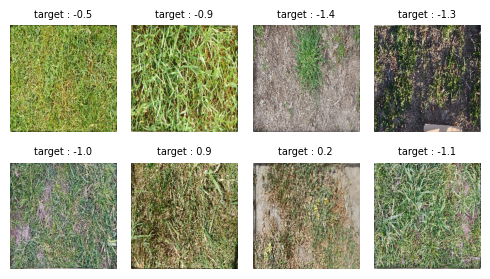

In [11]:

fig,axes = plt.subplots(2,4, figsize=(5 , 3 ))
axes = axes.flatten()

for img, tar in train_dataset.take(1):
    print(f'input shape : {img.shape}')
    print(f'target shape : {tar.shape}')
    print(f'number of images : {len(img)}')

    for i in range(min (8, len(img))):
        axes[i].imshow(img[i].numpy())
        axes[i].set_title(f'target : {tar[i,0].numpy():.1f}', fontsize = 7)
        axes[i].axis('off')
plt.tight_layout(); plt.show()


In [12]:
def baseline_model(
    input_shape = (224, 224, 3),
    n_targets = 5 ):

    augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1), 
        layers.RandomZoom(0.1),  
        layers.RandomBrightness(0.1),  
        layers.RandomContrast(0.1), 
    ], name='augmentation')

    model = keras.Sequential([
        layers.Input(shape=input_shape),

        augmentation,

        layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv1'),
        layers.BatchNormalization(name='bn1'),
        layers.MaxPooling2D((2,2), name='pool1'),
        layers.Dropout(0.3, name='dropout1'),

        layers.Conv2D(64, (3,3), activation='relu', padding='same', name='conv2'),
        layers.BatchNormalization(name='bn2'),
        layers.MaxPooling2D((2,2), name='pool2'),
        layers.Dropout(0.3, name='dropout2'),
        
        layers.Conv2D(128, (3,3), activation='relu', padding='same', name='conv3'),
        layers.BatchNormalization(name='bn3'),
        layers.MaxPooling2D((2,2), name='pool3'),
        layers.Dropout(0.3, name='dropout3'),

        layers.GlobalAveragePooling2D(name='gap2d'),
        
        layers.Dense(64, activation='relu', name='dense1'),
        layers.BatchNormalization(name='bn4'),
        layers.Dropout(0.3, name='dropout4'),

        layers.Dense(32, activation='relu', name='dense2'),
        layers.BatchNormalization(name='bn5'),
        layers.Dropout(0.3, name='dropout5'),

        layers.Dense(n_targets, name='target')
    ], name='baseline_model')

    return model


def get_nv2_model(input_shape = (224, 224, 3), n_targets = 5):

    base_nv2 = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_nv2.trainable = False

    nv2 = keras.Sequential([
        base_nv2,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'), 
        layers.Dense(5, name='target')
        ], name='nv2_model')

    return nv2


def get_eff_model(input_shape = (224, 224, 3), n_targets = 5):
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    eff = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'), 
        layers.Dense(5, name='target')
    ], name='eff_model')

    return eff


In [13]:
model_dir = os.path.join(project_path, "models") 

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = model_dir + '/best_baseline_model.keras', 
        monitor='val_loss', 
        save_best_only=True, 
        verbose = 1),
        
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1),    

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )]


optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_func = keras.losses.MeanSquaredError()
metrics   = [keras.metrics.MeanAbsoluteError(), keras.metrics.MeanSquaredError()]

In [ ]:
model = baseline_model()
model.compile( optimizer = optimizer, loss = loss_func, metrics = metrics)
history = model.fit( train_dataset, 
                      validation_data = valid_dataset, 
                      epochs = 50, 
                      callbacks = callbacks,
                      verbose = 1)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 2.7883 - mean_absolute_error: 1.2820 - mean_squared_error: 2.7883
Epoch 1: val_loss improved from None to 1.41642, saving model to /Users/kaheichoi/git_repo/csiro_biomass/models/best_baseline_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - loss: 2.7658 - mean_absolute_error: 1.2733 - mean_squared_error: 2.7658 - val_loss: 1.4164 - val_mean_absolute_error: 0.8314 - val_mean_squared_error: 1.4164 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 2.1698 - mean_absolute_error: 1.1123 - mean_squared_error: 2.1698
Epoch 2: val_loss did not improve from 1.41642
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 2.1765 - mean_absolute_error: 1.1115 - mean_squared_error: 2.1765 - val_loss: 1.4271 - val_mean_absolute_error: 0.8330 - val_mean_squared_error: 1.4271 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 1.9693 - mean_absolute_error: 1.0701 - mean_squared_e

In [14]:
model_nv2 = get_nv2_model()
model_nv2.compile(optimizer=optimizer, loss=loss_func, metrics=metrics)
history = model_nv2.fit(train_dataset, 
                        validation_data = valid_dataset, 
                        epochs = 50, 
                        callbacks = callbacks,
                        verbose = 1)

Epoch 1/50


2025-12-07 19:33:23.750500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 2.2285 - mean_absolute_error: 1.1631 - mean_squared_error: 2.2285
Epoch 1: val_loss improved from None to 1.47797, saving model to /Users/kaheichoi/git_repo/csiro_biomass/models/best_baseline_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - loss: 1.7953 - mean_absolute_error: 1.0456 - mean_squared_error: 1.7953 - val_loss: 1.4780 - val_mean_absolute_error: 0.8664 - val_mean_squared_error: 1.4780 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.4526 - mean_absolute_error: 0.9535 - mean_squared_error: 1.4526
Epoch 2: val_loss improved from 1.47797 to 1.26482, saving model to /Users/kaheichoi/git_repo/csiro_biomass/models/best_baseline_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 1.2508 - mean_absolute_error: 0.8780 - mean_squared_error: 1.2508 - val_loss: 1.2648 - val_mean_absolute_error: 0.7990 - val_mean_squared_error: 1.2648 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━

In [ ]:
model_eff = get_eff_model()

model_eff.compile(optimizer=optimizer, loss=loss_func, metrics=metrics)

model_eff.summary()

history = model_eff.fit(train_dataset, 
                        validation_data = valid_dataset, 
                        epochs = 50, 
                        callbacks = callbacks,
                        verbose = 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ target (Dense)                  │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,131,880 (15.76 MB)

 Trainable params: 82,309 (321.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/50


2025-12-07 19:25:37.516424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.2832 - mean_absolute_error: 0.8409 - mean_squared_error: 1.2832
Epoch 1: val_loss improved from None to 1.43073, saving model to /Users/kaheichoi/git_repo/csiro_biomass/models/best_baseline_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - loss: 1.1274 - mean_absolute_error: 0.7903 - mean_squared_error: 1.1274 - val_loss: 1.4307 - val_mean_absolute_error: 0.8046 - val_mean_squared_error: 1.4307 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.1245 - mean_absolute_error: 0.7587 - mean_squared_error: 1.1245
Epoch 2: val_loss improved from 1.43073 to 1.37438, saving model to /Users/kaheichoi/git_repo/csiro_biomass/models/best_baseline_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 1.0922 - mean_absolute_error: 0.7630 - mean_squared_error: 1.0922 - val_loss: 1.3744 - val_mean_absolute_error: 0.8355 - val_mean_squared_error: 1.3744 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━

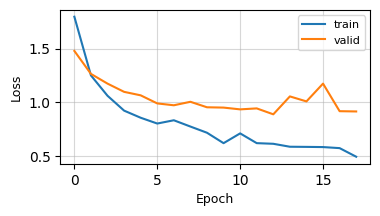

In [15]:
plt.figure(figsize=(4, 2))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'valid'], fontsize = 8)
plt.xlabel('Epoch',fontsize = 9)
plt.ylabel('Loss',fontsize = 9)
plt.grid(True, alpha=0.5)
plt.show()
